# PROJECT 2 - Continual Learning (CL) for Robotic Perception
---

* Richanshu Jha - rj1469@nyu.edu
* Disha Papneja - dp3074@nyu.edu

## Imports

Importing the required development library toolkits. Pytorch 4.0 is used for developing our neural nets.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import random
from PIL import Image

## Loading the MNIST Dataset
The data has been loaded from Kaggle. (This is the original MNIST dataset). It is a dataset of 28*28 grayscale images.  

In [2]:
##LOADING THE MNIST DATASET
trainData = pd.read_csv('../input/mnist-in-csv/mnist_train.csv')
testData = pd.read_csv('../input/mnist-in-csv/mnist_test.csv')

mnistData = pd.concat([trainData, testData], axis=0)
print('Merged data loaded with shape: ', str(mnistData.shape))

Merged data loaded with shape:  (70000, 785)


## Reshaping the data and getting the labels
The shape of each image is 28x28 pixels, which is why the shape of the Dataset is (N x 28 x 28)

In [3]:
labelData = mnistData['label'].to_numpy()
featureData = mnistData.drop(['label'], axis = 1)
featureData = featureData/255
featureData = featureData.to_numpy().reshape(featureData.shape[0], 28, 28)
print('Reshaped MNIST features shape: ', str(featureData.shape))
print('Reshaped MNIST labels shape: ', str(labelData.shape))

Reshaped MNIST features shape:  (70000, 28, 28)
Reshaped MNIST labels shape:  (70000,)


## Helper functions
Here, we define 3 important helper functions:
* `splitData`:   Splits the dataset into training and testing pairs according to the provided split ratio
* `rotateData`:  Takes a dataset of images and Rotates all images in it by the given rotation. This is to implement rotation in the MNIST dataset.
* `createTasks`: Creates 3 Tasks from a set of training and testing pairs. Each task is given a rotation. The algorithm to calculate the rotation for each task has been taken from the code in the repository that was provided along with the problem statement of the project, for the MNIST Rotations dataset.

In [4]:
#SPLITS DATA INTO TRAINING AND TESTING PAIRS
def splitData(features, labels, ttRatio):
    n = int(features.shape[0] * ttRatio)
    xTrain = features[:n] 
    xTest = features[n:]
    yTrain = labels[0:n]
    yTest = labels[n:]
    print('Split the data')
    print('Training features shape: ', str(xTrain.shape))
    print('Training labels shape: ', str(xTest.shape))
    print('Testing features shape: ', str(yTrain.shape))
    print('Testing features shape: ', str(yTest.shape))
    return(xTrain, xTest, yTrain, yTest)

#ROTATION ACCORIDING TO THE CODE PROVIDED FOR THE PROJECT
def rotateData(d, rotation):
    result = torch.FloatTensor(d.shape[0], 784)
    tensor = transforms.ToTensor()

    for i in range(d.shape[0]):
        img = Image.fromarray(d[i])
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result

#GENERATING TASKS. USING ROTATION OF THE DATASET FROM THE CODE PROVIDED IN THE MNIST DATASET LINK FOR THE PROJECT.
def createTasks(xTrain, xTest, yTrain, yTest, nTasks, minRot, maxRot):
    tasksTrain = []
    tasksTest = []
    for t in range(nTasks):
        minR = 1.0 * t / nTasks * (maxRot - minRot) + minRot
        maxR = 1.0 * (t + 1) / nTasks * (maxRot - minRot) + minRot
        rot = random.random() * (maxR - minR) + minR
        print('Creating Task ', str(t+1), ' With rotation %0.3f'%(rot))
        tasksTrain.append([rot, rotateData(xTrain, rot), yTrain])
        tasksTest.append([rot, rotateData(xTest, rot), yTest])
        
    print('Completed Creation of Tasks')
    return(np.array(tasksTrain), np.array(tasksTest))

## Initializing the Training and Testing pairs
A high ratio of 0.9 has been taken since we wanted to use as much data for training as possible, since we would be using deep neural networks which require large datasets to train. As a team we agreed at just 0.1 of the dataset (7000 images) would still be a reasonable amount of testing data. 

In [5]:
xTrain, xTest, yTrain, yTest = splitData(featureData, labelData, 0.9)

Split the data
Training features shape:  (63000, 28, 28)
Training labels shape:  (7000, 28, 28)
Testing features shape:  (63000,)
Testing features shape:  (7000,)


## Helper function to display images from the training, testing sets
The first 10 training images are displayed on the screen along with their labels for reference

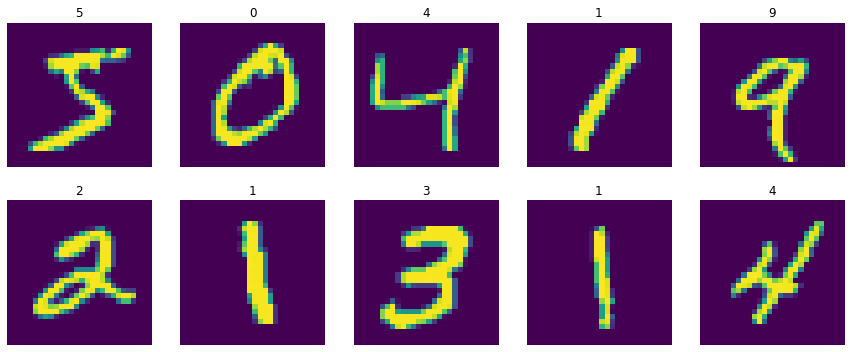

In [6]:
##HELPER FUNCTION TO DISPLAY THE IMAGES TO CHECK OUT OUR DATA
def displayImages(features,labels, m, n):
    f, axarr = plt.subplots(m,n)
    f.set_figheight(3*m)
    f.set_figwidth(3*n)
    x = 0
    for i in range(m):
        for j in range(n):
            if(m == 1):
                axarr[j].imshow(features[x])
                axarr[j].set_title(labels[x])
                axarr[j].axis('off')
            elif(n == 1):
                axarr[i].imshow(features[x])
                axarr[i].set_title(labels[x])
                axarr[i].axis('off')
            else:
                axarr[i, j].imshow(features[x])
                axarr[i, j].set_title(labels[x])
                axarr[i, j].axis('off')
            x += 1
            
displayImages(xTrain, yTrain, 2,5)

## The Neural Network
For this project, a fairly simple neural network is used. Since we are using different Rotations in the tasks, spatial relations would mostly be preserved across the Tasks (as opposed to using Permutations). Due to this we chose a convolutional network with 3 Convolution Layers and 2 fully connected layers.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## Training and testing functions
The following funtions are helper functions that we will use to train and test models. The batch size here is 256 and we run it for 3 epochs.

In [8]:

def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
        
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()

    print('Testing Accuracy: ' + str(correct) + '/' + str(len(t_test)) + ' -> %0.3f'%(correct / len(t_test)))
    return (100 * correct / len(t_test))


## Creation of Tasks

In [9]:
tasksTrain, tasksTest = createTasks(xTrain, xTest, yTrain, yTest, 3, 0, 90)
print(tasksTrain.shape)

Creating Task  1  With rotation 3.917
Creating Task  2  With rotation 52.183
Creating Task  3  With rotation 79.884
Completed Creation of Tasks
(3, 3)


## Displaying the result of applying rotations
Here, the first 5 images from each task have been displayed along with their labels.

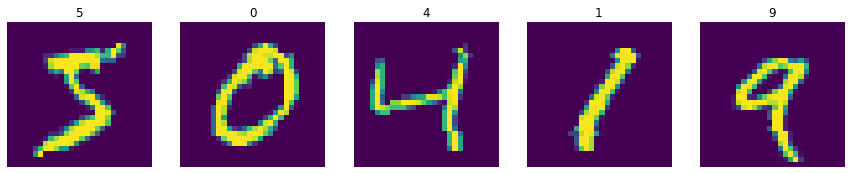

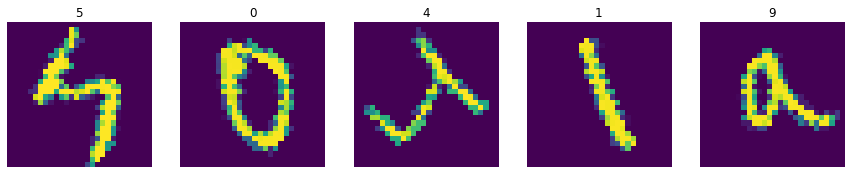

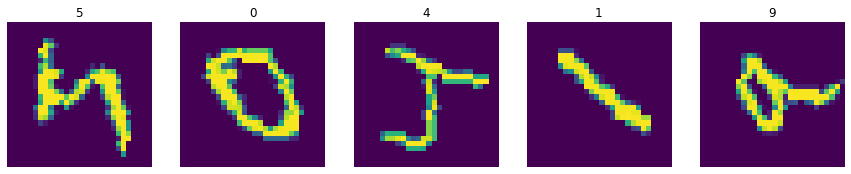

In [10]:
# CONVERTS THE TASKS WHICH HAVE TENSORS INTO PURELY ND ARRAY.
def npTasks(tasks):
    res = []
    for t in range(len(tasks)):
        res.append(np.array(tasks[t][1]).reshape(tasks[t][1].shape[0],28,28))
    return(np.array(res))

npTrain = npTasks(tasksTrain)
npTest = npTasks(tasksTest)

#SHOWING ROTATION TASKS (5 Per Task)
displayImages(npTrain[0], yTrain, 1, 5)
displayImages(npTrain[1], yTrain, 1, 5)
displayImages(npTrain[2], yTrain, 1, 5)

## Vanilla Neural Networks
Here we have first tested the results by directly using our neural network. For each task, we use the training set of that task. To calculate the accuracy, we test it with the test sets of each of the tasks. This is the model using no Continual Learning approach. We did this in order to compare it with the continual learning approach so as to compare the differences between the two.

In [11]:
## WITHOUT CONTINUAL LEARNING
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
model.float()
torch.manual_seed(1)

Results = []

#The model will be trained for each task and tested against the combined test sets of all tasks

def noCLTrainTest(xTrain, yTrain, xTest, yTest, epochs):
    res = []
    model = Net().to(device)
    model.float()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epochs):
        train(model, device, xTrain.reshape(xTrain.shape[0],1,28,28) , yTrain, optimizer, epoch)
        print('')
        res.append(test(model, device, xTest.reshape(xTest.shape[0],1,28,28) , yTest))
    return(res)

print('--------')
#TASK 1
xTr, yTr = npTrain[0], yTrain
xTe = np.concatenate([npTest[0], npTest[1], npTest[2]])
yTe = np.concatenate([yTest, yTest, yTest])
Results.append(noCLTrainTest(xTr ,yTr , xTe, yTe, 3))

print('--------')
#TASK 2
xTr, yTr = npTrain[1], yTrain
xTe = np.concatenate([npTest[0], npTest[1], npTest[2]])
yTe = np.concatenate([yTest, yTest, yTest])
Results.append(noCLTrainTest(xTr ,yTr , xTe, yTe, 3))

print('--------')
#TASK 3
xTr, yTr = npTrain[2], yTrain
xTe = np.concatenate([npTest[0], npTest[1], npTest[2]])
yTe = np.concatenate([yTest, yTest, yTest])
Results.append(noCLTrainTest(xTr ,yTr , xTe, yTe, 3))

--------
Train Epoch: 0 	Loss: 0.608436

Testing Accuracy: 9975/21000 -> 0.475
Train Epoch: 1 	Loss: 0.357130

Testing Accuracy: 10493/21000 -> 0.500
Train Epoch: 2 	Loss: 0.459821

Testing Accuracy: 11081/21000 -> 0.528
--------
Train Epoch: 0 	Loss: 0.672296

Testing Accuracy: 13490/21000 -> 0.642
Train Epoch: 1 	Loss: 0.329148

Testing Accuracy: 14201/21000 -> 0.676
Train Epoch: 2 	Loss: 0.185505

Testing Accuracy: 14394/21000 -> 0.685
--------
Train Epoch: 0 	Loss: 0.518586

Testing Accuracy: 11630/21000 -> 0.554
Train Epoch: 1 	Loss: 0.313933

Testing Accuracy: 12610/21000 -> 0.600
Train Epoch: 2 	Loss: 0.396159

Testing Accuracy: 13258/21000 -> 0.631


## Elastic Weights Consolidation
We considered multiple approaches to continual learning. Our final 2 options were Elastic weights consolidation, and using Rehearsal techniques. Rehearsal techniques are fairly straight forward to implement and can give a much higher accuracy than EWC if the entire previous dataset of previous is considered while training for the next tasks. In this implementation, there would be some tradeoff between acuracy and memory usage depending on how much of the past Tasks' datasets we choose to concatenate with the next one.

However, the project is continual Learning (CL) for Robotic Perception. If we consider the use case for robots, we must consider the fact that there would be a memory and time constraint. Here, increasing the dataset after each task means a linear increase in the memory and time requirements as time goes on hence we did not see this as an ideal method for this project. 

We have implemented Elastic Weight Consolidation which doesn't use any previous data. In this model we save the model parameters and the square of the gradients as the fisher and optpar data for each task. When we calculate the loss, we add an extra parameter to the loss: `(fisher * (optpar - param).pow(2)).sum() * ewcLambda`. This allows us to store some weight information from the previous tasks.

EWC is a part of a techniques called regularization. Regularization approaches alleviate catastrophic forgetting by imposing constraints on the updateof the neural weights.  Such approaches are typically inspired by theoretical neuroscience modelssuggesting  that  consolidated  knowledge  can  be  protected  from  forgetting  through  synapses  witha  cascade  of  states  yielding  different  levels  of  plasticity.From a computational perspective,  this is generally modelled via additional regularization terms that penalize changes in the mapping function of a neural network, like we did in our implementation of EWC.It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important wheights for the previous tasks.It has the great advantage of not using any of the previous tasks data!

In [12]:
## USING ELASTIC WEIGHTS CONSOLIDATION (REGULARIZATION)
fisherDict = {}
optparDict = {}
ewcLambda = 0.8

## CALLED FOR EACH TASK TO UPDATE THE FISHER AND OPTPAR DICTS
## THESE WILL BE USED TO CALCULATE THE LOSS
def updateGradientDicts(t, xTr, yTr):
    model.train()
    optimizer.zero_grad()

    #FINDING THE GRADIENTS
    for start in range(0, len(yTr)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(xTr[start:end]), torch.from_numpy(yTr[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()

    fisherDict[t] = {}
    optparDict[t] = {}

    #UPDATING THE GRADIENTS STORED IN FISHER AND OPTPAR DICT
    for name, param in model.named_parameters():
        optparDict[t][name] = param.data.clone()
        fisherDict[t][name] = param.grad.data.clone().pow(2)
    
#MODIFIED TRAINING METHOD WITH REGULARIZATION LOSS 
#CALCULATED USING THE FISHER AND OTPAR DICT VALUES)
def ewcTrain(model, device, t, xTr, yTr, optimizer, epoch):
    model.train()

    for start in range(0, len(yTr)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(xTr[start:end]), torch.from_numpy(yTr[start:end]).long()
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = F.cross_entropy(output, y)
        
        ## ADDITION OF REGULARIZATION LOSS
        for task in range(t):
            for name, param in model.named_parameters():
                if task in fisherDict:
                    fisher = fisherDict[task][name]
                    optpar = optparDict[task][name]
                    loss += (fisher * (optpar - param).pow(2)).sum() * ewcLambda
        
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

## Training and testing the EWC Model
The training and evaluation of the EWC model has been done in the same way as the non CL Model. The model is trained once for each task, with only the dataset associated with that task. The combined testing dataset of all tasks is used for the evaluation of the model. We need also to modify our train function to add the new regularization loss.

In [13]:
## TRAINING AND TESTING THE CONTINUAL LEARNING MODEL USING EWC
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def ewcCLTrainTest(xTrain, yTrain, xTest, yTest, epochs, t):
    res = []
    for epoch in range(epochs):
        ewcTrain(model, device, t, xTrain.reshape(xTrain.shape[0],1,28,28) , yTrain, optimizer, epoch)
        res.append(test(model, device, xTest.reshape(xTest.shape[0],1,28,28) , yTest))
        
    updateGradientDicts(t, xTrain.reshape(xTrain.shape[0],1,28,28), yTrain)
    return(res)

print('--------')
#TASK 1
xTr, yTr = npTrain[0], yTrain
xTe = np.concatenate([npTest[0], npTest[1], npTest[2]])
yTe = np.concatenate([yTest, yTest, yTest])
Results.append(ewcCLTrainTest(xTr ,yTr , xTe, yTe, 3, 0))

print('--------')
#TASK 2
xTr, yTr = npTrain[1], yTrain
xTe = np.concatenate([npTest[0], npTest[1], npTest[2]])
yTe = np.concatenate([yTest, yTest, yTest])
Results.append(ewcCLTrainTest(xTr ,yTr , xTe, yTe, 3, 1))

print('--------')
#TASK 3
xTr, yTr = npTrain[2], yTrain
xTe = np.concatenate([npTest[0], npTest[1], npTest[2]])
yTe = np.concatenate([yTest, yTest, yTest])
Results.append(ewcCLTrainTest(xTr ,yTr , xTe, yTe, 3, 2))

--------
Train Epoch: 0 	Loss: 0.500296
Testing Accuracy: 9928/21000 -> 0.473
Train Epoch: 1 	Loss: 0.536496
Testing Accuracy: 10693/21000 -> 0.509
Train Epoch: 2 	Loss: 0.480371
Testing Accuracy: 10782/21000 -> 0.513
--------
Train Epoch: 0 	Loss: 0.780990
Testing Accuracy: 16952/21000 -> 0.807
Train Epoch: 1 	Loss: 0.600745
Testing Accuracy: 16780/21000 -> 0.799
Train Epoch: 2 	Loss: 0.549500
Testing Accuracy: 16757/21000 -> 0.798
--------
Train Epoch: 0 	Loss: 0.783361
Testing Accuracy: 16480/21000 -> 0.785
Train Epoch: 1 	Loss: 1.022580
Testing Accuracy: 16400/21000 -> 0.781
Train Epoch: 2 	Loss: 0.759620
Testing Accuracy: 16325/21000 -> 0.777


## Plotting the Results
The accuracies of the models at their second epochs have been plotted. The x-axis is the number of tasks performed.

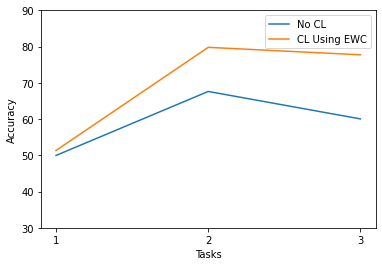

In [14]:
## Plotting the Results
Results = np.array(Results).reshape(2,3,3)

#TO FORCE X TO TAKE INTEGER VALUES ONLY
X = [1,2,3]
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
minVal, maxVal = min(Results.flatten()), max(Results.flatten())

plt.xlabel('Tasks')
plt.ylabel('Accuracy')
plt.ylim((minVal-minVal%10)-10, 10+(maxVal-maxVal%10))
plt.plot(X, Results[0,:,1], label = 'No CL')
plt.plot(X, Results[1,:,2], label = 'CL Using EWC')
plt.legend()
plt.show()

## Conclusion
It is evident from the graph that as the number of tasks increases, there is a significant relative increase in the accuracy of the model that applies the Continous Learning technique of Elastic Weights Consolidation, as compared to the model that that does not employ any Continous Learning Techniques. As discussed earlier, many other techniques can also be applied to this but some (for example: Naive method, Shuffled Rehersal techniques etc.) are not the best options for this since they result in an ever increasing memory requirement as the number of tasks increases which would bot not be an ideal solution for most cases of robotic perception. The strength of using EWC is that the memory requirement increments are negligible compared to these techniques. In general, a large number of real life applications in machine learning involve data is dynamic, streamed, or occurs in batches such that the model needs to retrain at constant intervals. it is noted and observed that Continual Learning techniques is the solution to these machine learning problems.